In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

from pandas import DataFrame, Series
from initializer import init
import utils

%matplotlib inline
plt.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

init()

# 1. Basic

## 1.1. Reminder

- cumulative return 산출

## 1.2. Weight

- 각 자산 비중(ratio)
- 특정 시점에서 항상 sum이 1이어야 함(진입 기준)
- e.g. Equal Weight Rebalancing

## 1.3. Return

- $ \text{Return of portfolio on day 1 } = {w_a}{r_a} + {w_b}{r_b} + {w_c}{r_c} + \dots $
- 1일 차의 $\sum$ (각 자신의 비중 * 각 자산의 return)

## 1.4. 중요한 포인트

- A 주가: [10, 12, 6](daily return: [+0.2, -0.5])
- B 주가: [10, 5, 6](daily return: [-0.5, +0.2])
- 각 10주씩 매수하고 buy & hold
---
- 위 1.3. 방식으로 수익률 계산하면...
  - 첫째날: `-0.15 (0.5 * 0.2 + 0.5 * -0.5)`
  - 둘째날: `-0.15 (0.5 * -0.5 + 0.5 * 0.2)`
  - 전체: `200 => 200 * (1 - 0.15) => 200 * (1 - 0.15)^2`
    - `[200, 170, 144.499999]`
---
- 그런데 포트폴리오 전체 value 관점에서 계산하면 `[200, 170, 120]`
  - 수익률은 `[0, -0.15, -0.294]`
---

> 첫째날이 지나면 포트폴리오의 weight가 달라지는 점을 유의하자.

### 1.4.1. Quiz

> 60:40 or 올웨더 전략 등 비중 기반 전략 진입 시, 비중만 유지하면 언제든 진입해도 될까?

안 되겠지

# 2. Buy & Hold

## 2.1. 구현

### 2.1.1. Data 준비

In [3]:
df = pd.DataFrame(
    {
        "A": [10, 15, 12, 13, 10, 11, 12],
        "B": [10, 10, 8, 13, 12, 12, 12],
        "C": [10, 12, 14, 16, 14, 14, 16],
    },
    index=pd.to_datetime(["2018-01-31", "2018-02-10", "2018-02-20", "2018-02-28", "2018-03-20", "2018-03-29", "2018-04-30",])
)
df

,A,B,C
2018-01-31,10,10,10
2018-02-10,15,10,12
2018-02-20,12,8,14
2018-02-28,13,13,16
2018-03-20,10,12,14
2018-03-29,11,12,14
2018-04-30,12,12,16


### 2.1.2. Shifted Return 구하기

In [4]:
"""이 상황에서는 Log Based Return을 사용할 수 없음을 기억하자"""
rtn_df = utils.get_returns_df(df, log=False)
rtn_df
"""shift 해야 해당 date에서 데이터를 가지고 있을 때 발생하는 수익률을 mapping 하기 쉬움"""
shifted_rtn_df = rtn_df.shift(-1).fillna(0)
shifted_rtn_df

'이 상황에서는 Log Based Return을 사용할 수 없음을 기억하자'

,A,B,C
2018-01-31,0.000,0.000,0.000
2018-02-10,0.500,0.000,0.200
2018-02-20,-0.200,-0.200,0.167
2018-02-28,0.083,0.625,0.143
2018-03-20,-0.231,-0.077,-0.125
2018-03-29,0.100,0.000,0.000
2018-04-30,0.091,0.000,0.143


'shift 해야 해당 date에서 데이터를 가지고 있을 때 발생하는 수익률을 mapping 하기 쉬움'

,A,B,C
2018-01-31,0.500,0.000,0.200
2018-02-10,-0.200,-0.200,0.167
2018-02-20,0.083,0.625,0.143
2018-02-28,-0.231,-0.077,-0.125
2018-03-20,0.100,0.000,0.000
2018-03-29,0.091,0.000,0.143
2018-04-30,0.000,0.000,0.000


In [5]:
cum_rtn_df = df / df.iloc[0]
cum_rtn_df

,A,B,C
2018-01-31,1.000,1.000,1.000
2018-02-10,1.500,1.000,1.200
2018-02-20,1.200,0.800,1.400
2018-02-28,1.300,1.300,1.600
2018-03-20,1.000,1.200,1.400
2018-03-29,1.100,1.200,1.400
2018-04-30,1.200,1.200,1.600


### 2.1.3. asset flow & weight df 구하기

In [6]:
"""A: 30%, B: 50%, C: 20%"""
WEIGHTS = [0.3, 0.5, 0.2]

assert sum(WEIGHTS) == 1

asset_flow_df = cum_rtn_df * WEIGHTS
asset_flow_df

'A: 30%, B: 50%, C: 20%'

,A,B,C
2018-01-31,0.300,0.500,0.200
2018-02-10,0.450,0.500,0.240
2018-02-20,0.360,0.400,0.280
2018-02-28,0.390,0.650,0.320
2018-03-20,0.300,0.600,0.280
2018-03-29,0.330,0.600,0.280
2018-04-30,0.360,0.600,0.320


In [7]:
port_weight_df = asset_flow_df.divide(asset_flow_df.sum(axis=1), axis=0)
port_weight_df

"""각 행의 값의 합은 항상 1로 유지"""
for i in range(len(port_weight_df)):
    assert sum(port_weight_df.iloc[i]) == 1
assert port_weight_df.sum(axis=1).sum() == len(port_weight_df)

,A,B,C
2018-01-31,0.300,0.500,0.200
2018-02-10,0.378,0.420,0.202
2018-02-20,0.346,0.385,0.269
2018-02-28,0.287,0.478,0.235
2018-03-20,0.254,0.508,0.237
2018-03-29,0.273,0.496,0.231
2018-04-30,0.281,0.469,0.250


'각 행의 값의 합은 항상 1로 유지'

### 2.1.4. 최종 portfolio return 구하기

In [8]:
net_rtn_df = port_weight_df * shifted_rtn_df
net_rtn_df

,A,B,C
2018-01-31,0.150,0.000,0.040
2018-02-10,-0.076,-0.084,0.034
2018-02-20,0.029,0.240,0.038
2018-02-28,-0.066,-0.037,-0.029
2018-03-20,0.025,0.000,0.000
2018-03-29,0.025,0.000,0.033
2018-04-30,0.000,0.000,0.000


In [9]:
"""계산을 위해 shift(-1) 했던 부분을 되돌리는 작업"""
net_rtn_df = net_rtn_df.shift(1).fillna(0)
net_rtn_df

'계산을 위해 shift(-1) 했던 부분을 되돌리는 작업'

,A,B,C
2018-01-31,0.000,0.000,0.000
2018-02-10,0.150,0.000,0.040
2018-02-20,-0.076,-0.084,0.034
2018-02-28,0.029,0.240,0.038
2018-03-20,-0.066,-0.037,-0.029
2018-03-29,0.025,0.000,0.000
2018-04-30,0.025,0.000,0.033


In [10]:
"""일별 포트폴리오 수익률 Series"""
rtn_series = net_rtn_df.sum(axis=1)
rtn_series

'일별 포트폴리오 수익률 Series'

2018-01-31    0.000
2018-02-10    0.190
2018-02-20   -0.126
2018-02-28    0.308
2018-03-20   -0.132
2018-03-29    0.025
2018-04-30    0.058
dtype: float64

'일별 포트폴리오 누적 수익률 Series'

2018-01-31   1.000
2018-02-10   1.190
2018-02-20   1.040
2018-02-28   1.360
2018-03-20   1.180
2018-03-29   1.210
2018-04-30   1.280
dtype: float64

<AxesSubplot:title={'center':'Buy & Hold 누적 수익률'}>

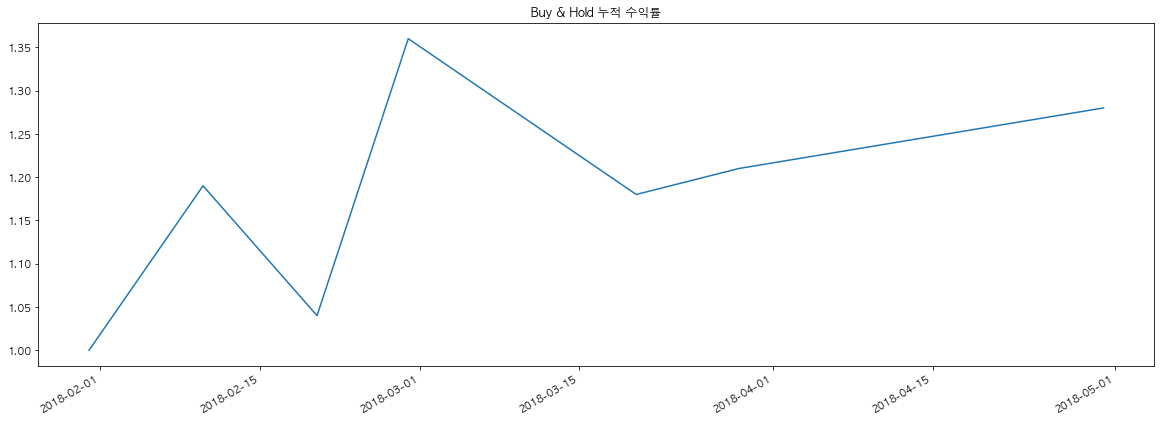

In [11]:
"""일별 포트폴리오 누적 수익률 Series"""
(rtn_series + 1).cumprod()
(rtn_series + 1).cumprod().plot(figsize=(20, 7), title="Buy & Hold 누적 수익률")

### 2.1.5. 개별종목 portval 구하기 - 두 번째 구현 방법

- "buy & hold"일 경우 이전에 구한 `asset_flow_df`와 동일

In [12]:
_df = pd.DataFrame({
    "A portval": [10, 12, 11, 5],
    "B portval": [40, 35, 37, 41],
    "Total portval": [50, 47, 48, 46]
})
_df

,A portval,B portval,Total portval
0,10,40,50
1,12,35,47
2,11,37,48
3,5,41,46


#### `asset_flow_df`가 개별 portval df인 이유 1

- $A(1 + r_{a1}) \rightarrow A(1 + r_{a1})(1 + r_{a2}) \rightarrow A(1 + r_{a1})(1 + r_{a2})(1 + r_{a3}) \rightarrow \dots$
- $0.1A(1 + r_{a1}) \rightarrow 0.1A(1 + r_{a1})(1 + r_{a2}) \rightarrow 0.1A(1 + r_{a1})(1 + r_{a2})(1 + r_{a3}) \rightarrow \dots$
- 처음 설정한 자산 $0.1A$에 $A$의 수익률이 그대로 복리 계산이 되기 때문에 계산이 망가지지 않는다.

In [13]:
individual_cum_rtn_df = cum_rtn_df * WEIGHTS
individual_cum_rtn_df

,A,B,C
2018-01-31,0.300,0.500,0.200
2018-02-10,0.450,0.500,0.240
2018-02-20,0.360,0.400,0.280
2018-02-28,0.390,0.650,0.320
2018-03-20,0.300,0.600,0.280
2018-03-29,0.330,0.600,0.280
2018-04-30,0.360,0.600,0.320


In [14]:
"""portval"""
individual_cum_rtn_df.sum(axis=1)

'portval'

2018-01-31   1.000
2018-02-10   1.190
2018-02-20   1.040
2018-02-28   1.360
2018-03-20   1.180
2018-03-29   1.210
2018-04-30   1.280
dtype: float64

#### `asset_flow_df`가 개별 portval df인 이유 2

> 직접 식으로 표현하고 비교하기 - e.g. A : B = 40 : 60 전략

##### individual 관점

- day 1
  - A: $0.4$
  - B: $0.6$
  - +: $1$
- day 2
  - A: $0.4(1 + r_{a1})$
  - B: $0.6(1 + r_{b1})$
  - +: $1 + 0.4r_{a1} + 0.6r_{b1}$
- day 3
  - A: $0.4(1 + r_{a1})(1 + r_{a2}) = 0.4(1 + r_{a1} + r_{a2} + r_{a1}r_{a2})$
  - B: $0.6(1 + r_{b1})(1 + r_{b2}) = 0.4(1 + r_{b1} + r_{b2} + r_{b1}r_{b2})$
  - +: $1 + 0.4(r_{a1} + r_{a2} + r_{a1}r_{a2}) + 0.6(r_{b1} + r_{b2} + r_{b1}r_{b2})$
    - $(1 + 0.4r_{a1} + 0.6r_{b1}) + 0.4(r_{a2} + r_{a1}r_{a2}) + 0.6(r_{b2} + r_{b1}r_{b2})$

##### portfolio 관점

- day 1
  - $1$
- day 2
  - $1 \times (1 + (0.4r_{a1} + 0.6r_{b1}))$
- day 3
  - $1 \times (1 + (0.4r_{a1} + 0.6r_{b1})) \times (1 + \dots)$

$$
\begin{aligned}
1 \times (1 + 0.4r_{a1} + 0.6r_{b1}) \times (1 + \dots)
&= 1 \times (1 + 0.4r_{a1} + 0.6r_{b1}) \times
(1 + \frac{0.4(1 + r_{a1}) \times r_{a2}}{0.4(1 + r_{a1}) + 0.6(1 + r_{b1})} + 
\frac{0.6(1 + r_{b1}) \times r_{b2}}{0.4(1 + r_{a1}) + 0.6(1 + r_{b1})})\\
&= 1 \times (1 + 0.4r_{a1} + 0.6r_{b1}) \times
(1 + \frac{0.4(1 + r_{a1}) \times r_{a2} + 0.6(1 + r_{b1}) \times r_{b2}}{0.4(1 + r_{a1}) + 0.6(1 + r_{b1})}) \\
&= 1 \times (1 + 0.4r_{a1} + 0.6r_{b1}) \times
(1 + \frac{0.4(1 + r_{a1}) \times r_{a2} + 0.6(1 + r_{b1}) \times r_{b2}}{1 + 0.4r_{a1} + 0.6r_{b1}}) \\
&= 1 \times ((1 + 0.4r_{a1} + 0.6r_{b1}) + (0.4(1 + r_{a1}) \times r_{a2} + 0.6(1 + r_{b1}) \times r_{b2})) \\
&= 1 \times (1 + 0.4r_{a1} + 0.6r_{b1} + 0.4r_{a2} + 0.4r_{a1}r_{a2} + 0.6r_{b2} + 0.6r_{b1}r_{b2}) \\
&= 1 \times ((1 + 0.4r_{a1} + 0.6r_{b1}) + (0.4(r_{a2} + r_{a1}r_{a2}) + 0.6(r_{b2} + r_{b1}r_{b2}))) \\
&= (1 + 0.4r_{a1} + 0.6r_{b1}) + 0.4(r_{a2} + r_{a1}r_{a2}) + 0.6(r_{b2} + r_{b1}r_{b2})
\end{aligned}
$$

## 2.2. 실수할 만한 내용

In [15]:
df.head()

,A,B,C
2018-01-31,10,10,10
2018-02-10,15,10,12
2018-02-20,12,8,14
2018-02-28,13,13,16
2018-03-20,10,12,14


In [16]:
rtn_df = utils.get_returns_df(df, log=False)
cum_rtn_df = df / df.iloc[0]

a_1 = (cum_rtn_df * (1 / 3)).sum(axis=1)
a_2 = ((rtn_df * (1 / 3)).sum(axis=1) + 1).cumprod()

"""왜 결과가 다를까"""
a_1
a_2

"""매일 반영된 weight가 틀어졌기 때문이다."""
"""cumulative * weight != return * weight"""

'왜 결과가 다를까'

2018-01-31   1.000
2018-02-10   1.233
2018-02-20   1.133
2018-02-28   1.400
2018-03-20   1.200
2018-03-29   1.233
2018-04-30   1.333
dtype: float64

2018-01-31   1.000
2018-02-10   1.233
2018-02-20   1.137
2018-02-28   1.460
2018-03-20   1.250
2018-03-29   1.291
2018-04-30   1.392
dtype: float64

'매일 반영된 weight가 틀어졌기 때문이다.'

'cumulative * weight != return * weight'

## 2.3. 주의사항

- 2018/1/1부터 0.5/0.5씩 들고 있는 것과 2018/10/1부터 0.5/0.5씩 들고 있는 것은 결과가 다르다.

In [17]:
df = pd.read_csv("class_materials/data/us_etf_1.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,IEF,QQQ,SHY,SPY,TLT
date_time,,,,,
2002-07-26,48.724,19.653,59.443,59.178,43.084
2002-07-29,48.153,20.658,59.245,61.989,42.504
2002-07-30,48.124,21.075,59.223,62.797,42.567
2002-07-31,48.565,20.676,59.406,62.976,43.094
2002-08-01,48.765,19.705,59.523,61.305,43.340


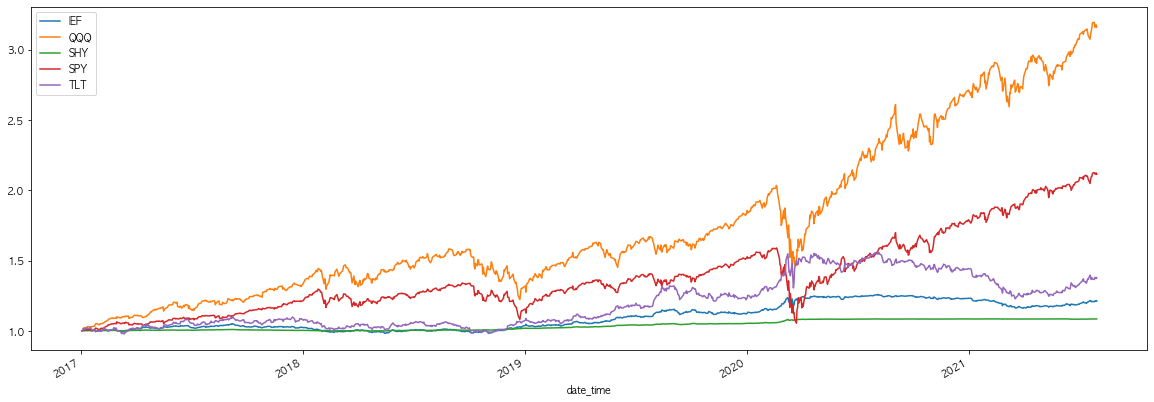

In [18]:
df_1 = df.loc["2017-01-01":]
cum_rtn_df = df_1 / df_1.iloc[0]

cum_rtn_df.plot(figsize=(20, 7));

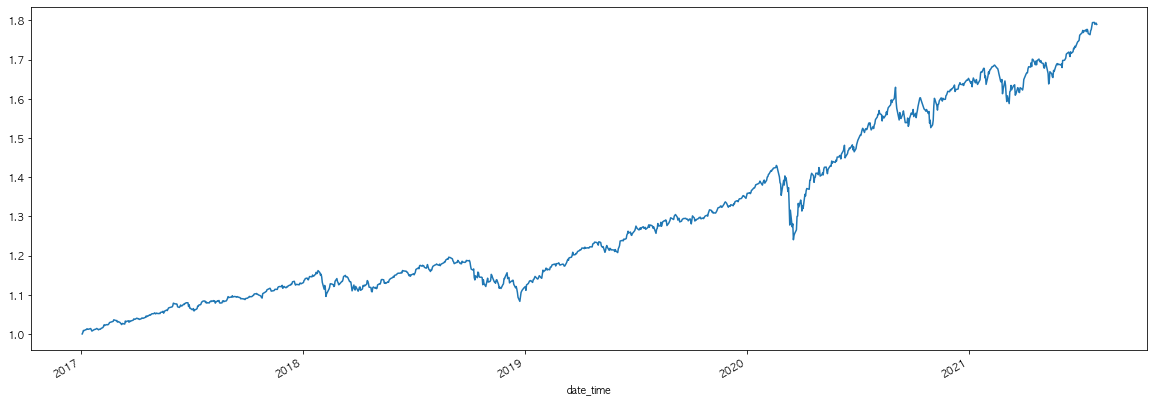

In [19]:
allocation = [0.2] * 5
allocation_df = cum_rtn_df * allocation

allocation_df.sum(axis=1).plot(figsize=(20, 7));

In [20]:
df_2 = cum_rtn_df.loc["2020-01-02":]
cum_rtn_df_2 = df_2 / df_2.iloc[0]
allocation_df_2 = cum_rtn_df_2 * allocation

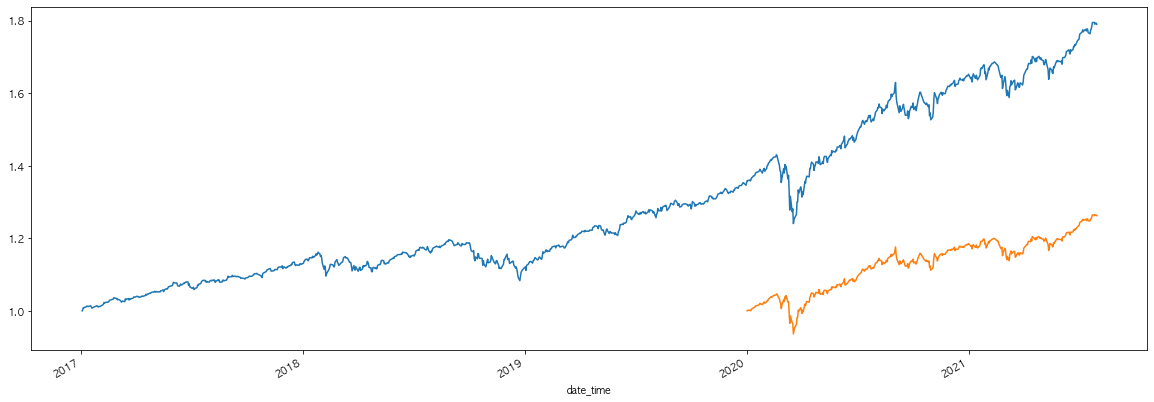

In [21]:
ax = allocation_df.sum(axis=1).plot(figsize=(20, 7))
allocation_df_2.sum(axis=1).plot(ax=ax);

In [22]:
allocation_df_2.head()

,IEF,QQQ,SHY,SPY,TLT
date_time,,,,,
2020-01-02,0.200,0.200,0.200,0.200,0.200
2020-01-03,0.201,0.198,0.200,0.198,0.203
2020-01-06,0.201,0.199,0.200,0.199,0.202
2020-01-07,0.201,0.199,0.200,0.199,0.201
2020-01-08,0.200,0.201,0.200,0.200,0.200


In [23]:
allocation_df.loc["2020-01-02"]
allocation_df.loc["2020-01-02"].sum()

IEF   0.225
QQQ   0.371
SHY   0.211
SPY   0.305
TLT   0.247
Name: 2020-01-02 00:00:00, dtype: float64

1.3588167271181084

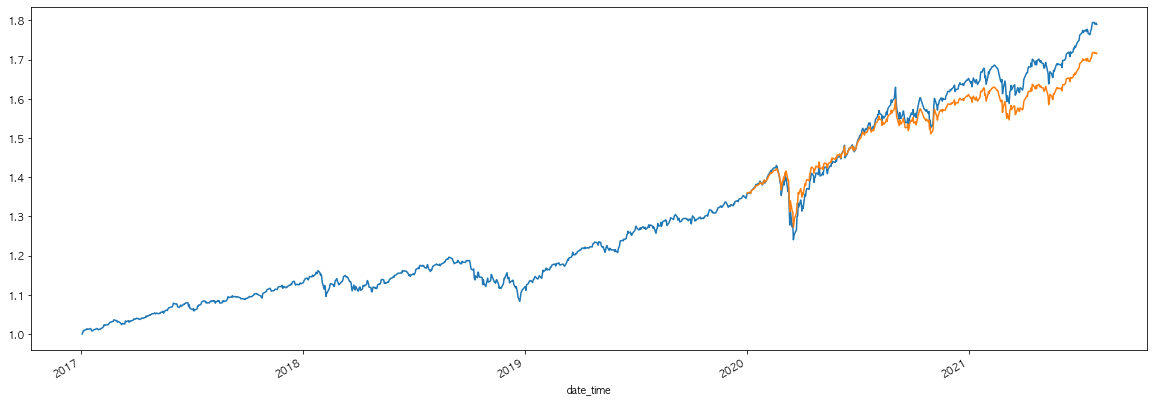

In [24]:
ax = allocation_df.sum(axis=1).plot(figsize=(20, 7))
(allocation_df_2.sum(axis=1) * allocation_df.loc["2020-01-02"].sum()).plot(ax=ax);

# 3. Periodic Weight Rebalancing

## 3.1. `Simple Return * Weight` 방법

- recab
  - `shifted_rtn_df`는 내 전략과 상관없이, 시장에서 각 종목 수익률을 담은 raw data
  - `weight_df`는 전략 로직이 들어있는 데이터
    - 중요한 점은 항상 `asset_flow_df`를 통해 구해야 한다는 것이다.
    - 예를 들어, `[0.3, 0.5, 0.2]` 상태에서, 며칠 후 해당 자산들 비율이 `[0.29, 0.49, 0.19]`가 되고 할 것인데,
      이런 자산의 흐름을 계산하는 `asset_flow_df`로 먼저구하고, 이 `dataframe`을 `axis=1` 방향으로 normalizing 하면 `weight_df`이다.
  - 이 둘의 조합을 가지고 어떻게 포트폴리오를 표현할 것인가가 관건

### 3.1.1. 구현

In [25]:
df = pd.DataFrame(
    {
        "A": [10, 15, 12, 13, 10, 11, 12],
        "B": [10, 10, 8, 13, 12, 12, 12],
        "C": [10, 12, 14, 16, 14, 14, 16],
    },
    index=pd.to_datetime(["2018-01-31", "2018-02-10", "2018-02-20", "2018-02-28", "2018-03-20", "2018-03-29", "2018-04-30",])
)
df

,A,B,C
2018-01-31,10,10,10
2018-02-10,15,10,12
2018-02-20,12,8,14
2018-02-28,13,13,16
2018-03-20,10,12,14
2018-03-29,11,12,14
2018-04-30,12,12,16


In [26]:
rtn_df = utils.get_returns_df(df, log=False)
shifted_rtn_df = rtn_df.shift(-1).fillna(0)   
shifted_rtn_df

,A,B,C
2018-01-31,0.500,0.000,0.200
2018-02-10,-0.200,-0.200,0.167
2018-02-20,0.083,0.625,0.143
2018-02-28,-0.231,-0.077,-0.125
2018-03-20,0.100,0.000,0.000
2018-03-29,0.091,0.000,0.143
2018-04-30,0.000,0.000,0.000


In [27]:
"""월말(월의 마지막) 데이터 인덱스 추출"""
df['year'] = df.index.year
df['month'] = df.index.month

rebal_index = df.drop_duplicates(['year','month'], keep="last").index
df.drop(['year', 'month'], axis=1, inplace=True)

rebal_index

'월말(월의 마지막) 데이터 인덱스 추출'

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-29', '2018-04-30'], dtype='datetime64[ns]', freq=None)

In [28]:
"""현재 월마다 리밸런싱을 하는 예제로 보는 것을 가정한다."""
"""그렇다면 리밸런싱 직전, 즉 리밸런싱을 하기 전 1달 동안은 Buy & Hold 전략으로도 볼 수 있다."""
"""다음은 해당 기간 누적 수익률을 구하는 작업이다."""

month_cum_rtn_df_list = []

for start, end in zip(rebal_index[:-1], rebal_index[1:]):
    month_price_df = df.loc[start:end]
    month_cum_rtn_df = month_price_df / month_price_df.iloc[0]
    month_cum_rtn_df_list.append(month_cum_rtn_df)

month_cum_rtn_df_list

'현재 월마다 리밸런싱을 하는 예제로 보는 것을 가정한다.'

'그렇다면 리밸런싱 직전, 즉 리밸런싱을 하기 전 1달 동안은 Buy & Hold 전략으로도 볼 수 있다.'

'다음은 해당 기간 누적 수익률을 구하는 작업이다.'

[               A     B     C
 2018-01-31 1.000 1.000 1.000
 2018-02-10 1.500 1.000 1.200
 2018-02-20 1.200 0.800 1.400
 2018-02-28 1.300 1.300 1.600,
                A     B     C
 2018-02-28 1.000 1.000 1.000
 2018-03-20 0.769 0.923 0.875
 2018-03-29 0.846 0.923 0.875,
                A     B     C
 2018-03-29 1.000 1.000 1.000
 2018-04-30 1.091 1.000 1.143]

In [29]:
"""뽑아낸 누적 수익률 데이터들을 이어붙인다."""
monthly_asset_flow_df = pd.concat(month_cum_rtn_df_list)
monthly_asset_flow_df
"""월말 데이터가 중복되는 것을 확인할 수 있다."""

'뽑아낸 누적 수익률 데이터들을 이어붙인다.'

,A,B,C
2018-01-31,1.000,1.000,1.000
2018-02-10,1.500,1.000,1.200
2018-02-20,1.200,0.800,1.400
2018-02-28,1.300,1.300,1.600
2018-02-28,1.000,1.000,1.000
2018-03-20,0.769,0.923,0.875
2018-03-29,0.846,0.923,0.875
2018-03-29,1.000,1.000,1.000
2018-04-30,1.091,1.000,1.143


'월말 데이터가 중복되는 것을 확인할 수 있다.'

In [30]:
"""중복된 데이터 중 마지막 것만 남긴다."""
"""월말에 구해진 주기 최종 누적 수익률은 현 시점에서 관심이 없는 데이터이다."""
"""월말에 리밸런싱을 했다면, 다음 달부터는 리밸런싱된 후 자연스럽게 데이터를 관리하기 위함이다."""

monthly_asset_flow_df.index.duplicated(keep="last")

monthly_asset_flow_df = monthly_asset_flow_df.loc[~monthly_asset_flow_df.index.duplicated(keep="last")] # check NOT Operator
monthly_asset_flow_df

'중복된 데이터 중 마지막 것만 남긴다.'

'월말에 구해진 주기 최종 누적 수익률은 현 시점에서 관심이 없는 데이터이다.'

'월말에 리밸런싱을 했다면, 다음 달부터는 리밸런싱된 후 자연스럽게 데이터를 관리하기 위함이다.'

array([False, False, False,  True, False, False,  True, False, False])

,A,B,C
2018-01-31,1.000,1.000,1.000
2018-02-10,1.500,1.000,1.200
2018-02-20,1.200,0.800,1.400
2018-02-28,1.000,1.000,1.000
2018-03-20,0.769,0.923,0.875
2018-03-29,1.000,1.000,1.000
2018-04-30,1.091,1.000,1.143


In [31]:
"""monthly_asset_flow_df에 weight를 곱하면 누적 수익률 비중을 구할 수 있다."""
WEIGHTS = [0.3, 0.5, 0.2]

assert sum(WEIGHTS) == 1

monthly_asset_flow_df = monthly_asset_flow_df * WEIGHTS
monthly_asset_flow_df

'monthly_asset_flow_df에 weight를 곱하면 누적 수익률 비중을 구할 수 있다.'

,A,B,C
2018-01-31,0.300,0.500,0.200
2018-02-10,0.450,0.500,0.240
2018-02-20,0.360,0.400,0.280
2018-02-28,0.300,0.500,0.200
2018-03-20,0.231,0.462,0.175
2018-03-29,0.300,0.500,0.200
2018-04-30,0.327,0.500,0.229


In [32]:
"""드디어 각 종목의 전체 자산 비중을 구할 준비가 되었다."""

# 자산 비중의 흐름을 일별로 sum=1이 되게 만들면 결국 weight_df
weight_df = monthly_asset_flow_df.divide(monthly_asset_flow_df.sum(axis=1), axis=0)
weight_df

'드디어 각 종목의 전체 자산 비중을 구할 준비가 되었다.'

,A,B,C
2018-01-31,0.300,0.500,0.200
2018-02-10,0.378,0.420,0.202
2018-02-20,0.346,0.385,0.269
2018-02-28,0.300,0.500,0.200
2018-03-20,0.266,0.532,0.202
2018-03-29,0.300,0.500,0.200
2018-04-30,0.310,0.474,0.216


In [33]:
"""이제 shifted_rtn_df와 곱해보자."""
net_rtn_df = shifted_rtn_df * weight_df
net_rtn_df

'이제 shifted_rtn_df와 곱해보자.'

,A,B,C
2018-01-31,0.150,0.000,0.040
2018-02-10,-0.076,-0.084,0.034
2018-02-20,0.029,0.240,0.038
2018-02-28,-0.069,-0.038,-0.025
2018-03-20,0.027,0.000,0.000
2018-03-29,0.027,0.000,0.029
2018-04-30,0.000,0.000,0.000


In [34]:
"""계산을 위해 shift 했던 것을 되돌리고 합해주면 최종적으로 일별 수익률을 구하게 된다."""
rtn_series = net_rtn_df.sum(axis=1).shift(1).fillna(0)
rtn_series

'계산을 위해 shift 했던 것을 되돌리고 합해주면 최종적으로 일별 수익률을 구하게 된다.'

2018-01-31    0.000
2018-02-10    0.190
2018-02-20   -0.126
2018-02-28    0.308
2018-03-20   -0.133
2018-03-29    0.027
2018-04-30    0.056
dtype: float64

In [35]:
"""누적 수익률은 다음과 같이 구한다."""
(rtn_series + 1).cumprod()

'누적 수익률은 다음과 같이 구한다.'

2018-01-31   1.000
2018-02-10   1.190
2018-02-20   1.040
2018-02-28   1.360
2018-03-20   1.180
2018-03-29   1.211
2018-04-30   1.279
dtype: float64

## 3.2. `Cumulative Return` 방법

> event based.

3.1. 방식보다 편리하고 확장성이 좋아 자주 사용된다.
하지만 3.1. 방식을 아예 안 쓰거나, 해당 방법이 반드시 필요한 경우도 있기 때문에 기억해두자.

### 3.2.1. 구현

In [36]:
"""예제 데이터 준비"""
df = pd.DataFrame(
    {
        "A": [10, 15, 12, 13, 10, 11, 12],
        "B": [10, 10, 8, 13, 12, 12, 12],
        "C": [10, 12, 14, 16, 14, 14, 16],
    },
    index=pd.to_datetime(["2018-01-31", "2018-02-10", "2018-02-20", "2018-02-28", "2018-03-20", "2018-03-29", "2018-04-30",])
)
df['year'] = df.index.year
df['month'] = df.index.month

rebal_index = df.drop_duplicates(['year','month'], keep="last").index
df.drop(['year', 'month'], axis=1, inplace=True)

"""3.1. 방식과 동일한 부분이라 자세한 설명은 생략"""

'예제 데이터 준비'

'3.1. 방식과 동일한 부분이라 자세한 설명은 생략'

In [37]:
"""만들고자 하는 weight_df 형태"""
target_weight_df = pd.DataFrame(
    [[0.3, 0.5, 0.2]]* len(rebal_index),
    index=rebal_index,
    columns=df.columns
)
target_weight_df

'만들고자 하는 weight_df 형태'

,A,B,C
2018-01-31,0.300,0.500,0.200
2018-02-28,0.300,0.500,0.200
2018-03-29,0.300,0.500,0.200
2018-04-30,0.300,0.500,0.200


In [38]:
# 월별 포트폴리오 자산 목록
individual_port_val_df_list = []

# 직전 달의 마지막 누적 수익률 - 로직의 일관성을 위해 1로 설정함
cum_rtn_at_last_month_end = 1

# 직전 달(리밸런싱 주기)의 마지막 인덱스
prev_end_day = rebal_index[0]

# for loop 사용을 통해 event-based 방식이 가미되었다는 것을 알 수 있다.
for end_day in rebal_index[1:]:
    # 주기만큼 서브셋을 뽑아냄
    sub_price_df = df.loc[prev_end_day:end_day]
    sub_cum_rtn_df = sub_price_df / sub_price_df.iloc[0]

    weight_series = target_weight_df.loc[prev_end_day]
    # (sub_cum_rtn_df * weight_series): 첫 설정한 weight이 asset 크기의 흐름에 따라 어떻게 변화하는지를 계산함
    indi_port_cum_rtn_df = (sub_cum_rtn_df * weight_series) * cum_rtn_at_last_month_end

    # 주기별 포트폴리오 결과 기록
    individual_port_val_df_list.append(indi_port_cum_rtn_df)

    # 이번 주기 최종 누적 수익률 시리즈
    total_port_cum_rtn_series = indi_port_cum_rtn_df.sum(axis=1)

    # 직전 주기 마지막 누적 수익률 갱신
    cum_rtn_at_last_month_end = total_port_cum_rtn_series.iloc[-1]

    # 직전 주기 마지막 인덱스 갱신
    prev_end_day = end_day

In [39]:
"""주기별 각 포트폴리오 자산"""
individual_port_val_df_list

'주기별 각 포트폴리오 자산'

[               A     B     C
 2018-01-31 0.300 0.500 0.200
 2018-02-10 0.450 0.500 0.240
 2018-02-20 0.360 0.400 0.280
 2018-02-28 0.390 0.650 0.320,
                A     B     C
 2018-02-28 0.408 0.680 0.272
 2018-03-20 0.314 0.628 0.238
 2018-03-29 0.345 0.628 0.238,
                A     B     C
 2018-03-29 0.363 0.605 0.242
 2018-04-30 0.396 0.605 0.277]

#### 리밸런싱 날, 리밸런싱 바로 직전의 자산 flow 선택

In [40]:
result_port_df_list = [individual_port_val_df_list[0]]
for _df in individual_port_val_df_list[1:]:
    result_port_df_list.append(_df.iloc[1:])

result1_ind = pd.concat(result_port_df_list)
result1_port = result1_ind.sum(axis=1)

#### 리밸런싱 날, 리밸런싱 직후의 자산 flow 선택

In [41]:
result_port_df_list = []
for i, _df in enumerate(individual_port_val_df_list):
    if i == len(individual_port_val_df_list)-1:
        result_port_df_list.append(_df)
    else:
        result_port_df_list.append(_df.iloc[:-1])

result2_ind = pd.concat(result_port_df_list)
result2_port = result1_ind.sum(axis=1)

In [42]:
"""포트폴리오 누적 자산을 3.1. 방식으로 구한 것과 3.2. 방식으로 구한 것의 비교"""
assert (rtn_series + 1).cumprod().equals(result2_port)
"""리밸런싱 주기별 선택한 주기의 결과에 따른 값 비교"""
assert result1_port.equals(result2_port)

'포트폴리오 누적 자산을 3.1. 방식으로 구한 것과 3.2. 방식으로 구한 것의 비교'

'리밸런싱 주기별 선택한 주기의 결과에 따른 값 비교'

In [43]:
"""두 주기별 포트폴리오 비교 - 리밸런싱 당일만 값이 다름"""
result1_ind
result2_ind

'두 주기별 포트폴리오 비교 - 리밸런싱 당일만 값이 다름'

,A,B,C
2018-01-31,0.300,0.500,0.200
2018-02-10,0.450,0.500,0.240
2018-02-20,0.360,0.400,0.280
2018-02-28,0.390,0.650,0.320
2018-03-20,0.314,0.628,0.238
2018-03-29,0.345,0.628,0.238
2018-04-30,0.396,0.605,0.277


,A,B,C
2018-01-31,0.300,0.500,0.200
2018-02-10,0.450,0.500,0.240
2018-02-20,0.360,0.400,0.280
2018-02-28,0.408,0.680,0.272
2018-03-20,0.314,0.628,0.238
2018-03-29,0.363,0.605,0.242
2018-04-30,0.396,0.605,0.277


In [44]:
from matplotlib.pyplot import stackplot

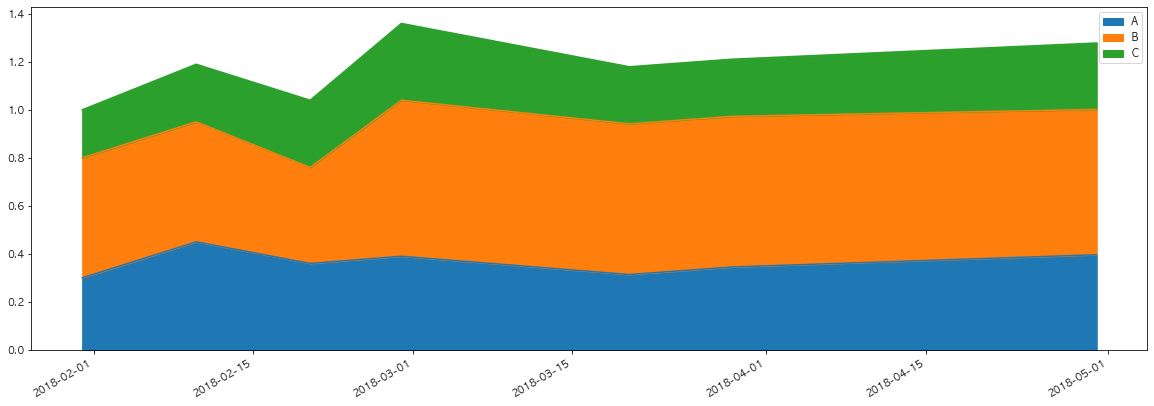

In [45]:
result1_ind.plot.area(figsize=(20, 7));

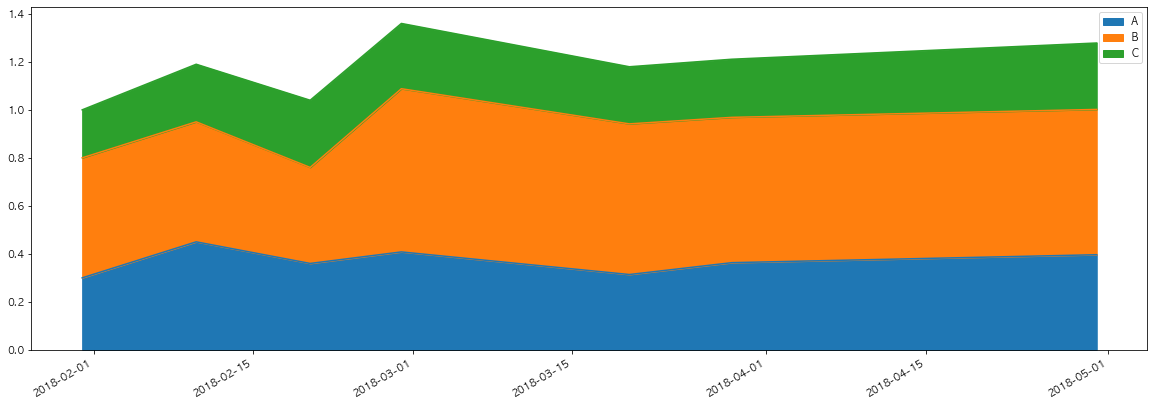

In [46]:
result2_ind.plot.area(figsize=(20, 7));

# 4. 실전연습

## 4.1. 동일가중(equal weight)

In [47]:
price_df = pd.read_csv("class_materials/data/us_etf_1.csv", index_col=[0], parse_dates=True).drop(
    ["SHY", "TLT", "SPY"], axis=1
)
price_df.head()

,IEF,QQQ
date_time,,
2002-07-26,48.724,19.653
2002-07-29,48.153,20.658
2002-07-30,48.124,21.075
2002-07-31,48.565,20.676
2002-08-01,48.765,19.705


In [48]:
price_df['year'] = price_df.index.year
price_df['month'] = price_df.index.month

rebal_index = price_df.drop_duplicates(subset=['year', 'month'], keep='last').index
price_df = price_df.drop(['year', 'month'], axis=1)

rebal_index

DatetimeIndex(['2002-07-31', '2002-08-30', '2002-09-30', '2002-10-31',
               '2002-11-29', '2002-12-31', '2003-01-31', '2003-02-28',
               '2003-03-31', '2003-04-30',
               ...
               '2020-10-30', '2020-11-30', '2020-12-31', '2021-01-29',
               '2021-02-26', '2021-03-31', '2021-04-30', '2021-05-28',
               '2021-06-30', '2021-07-30'],
              dtype='datetime64[ns]', name='date_time', length=229, freq=None)

In [49]:
target_weight_df = pd.DataFrame(
    [[1 / len(price_df.columns)] * len(price_df.columns)] * len(rebal_index),
    index=rebal_index,
    columns=price_df.columns
)

target_weight_df

,IEF,QQQ
date_time,,
2002-07-31,0.500,0.500
2002-08-30,0.500,0.500
2002-09-30,0.500,0.500
2002-10-31,0.500,0.500
2002-11-29,0.500,0.500
...,...,...
2021-03-31,0.500,0.500
2021-04-30,0.500,0.500
2021-05-28,0.500,0.500


In [50]:
"""cumulative 방식으로 리밸런싱 적용"""

cum_rtn_at_last_month_end = 1
individual_port_val_df_list = []

prev_end_day = rebal_index[0]
for end_day in rebal_index[1:]:
    sub_price_df = price_df.loc[prev_end_day:end_day]
    sub_cum_rtn_df = sub_price_df / sub_price_df.iloc[0]

    weight_series = target_weight_df.loc[prev_end_day]
    indi_port_cum_rtn_df = (sub_cum_rtn_df * weight_series) * cum_rtn_at_last_month_end

    individual_port_val_df_list.append(indi_port_cum_rtn_df)

    total_port_cum_rtn_series = indi_port_cum_rtn_df.sum(axis=1)
    cum_rtn_at_last_month_end = total_port_cum_rtn_series.iloc[-1]

    prev_end_day = end_day

'cumulative 방식으로 리밸런싱 적용'

In [51]:
"""전체 기간 주기별 포트폴리오 밸런스"""
from functools import reduce

all_ind_portval_df = reduce(lambda x, y: pd.concat([x, y.iloc[1:]]), individual_port_val_df_list)
all_ind_portval_df

'전체 기간 주기별 포트폴리오 밸런스'

,IEF,QQQ
date_time,,
2002-07-31,0.500,0.500
2002-08-01,0.502,0.477
2002-08-02,0.506,0.466
2002-08-05,0.508,0.449
2002-08-06,0.504,0.472
...,...,...
2021-07-26,3.608,3.696
2021-07-27,3.623,3.655
2021-07-28,3.626,3.669


In [52]:
"""QQQ 종목만 Buy & Hold 했을 경우의 기대 수익률"""
price_df = price_df.loc[all_ind_portval_df.index[0]:]
buy_and_hold_series = price_df["QQQ"] / price_df["QQQ"].iloc[0]
buy_and_hold_series

'QQQ 종목만 Buy & Hold 했을 경우의 기대 수익률'

date_time
2002-07-31    1.000
2002-08-01    0.953
2002-08-02    0.933
2002-08-05    0.899
2002-08-06    0.943
              ...  
2021-07-26   17.822
2021-07-27   17.626
2021-07-28   17.694
2021-07-29   17.725
2021-07-30   17.633
Name: QQQ, Length: 4784, dtype: float64

In [53]:
"""포트폴리오와 QQQ 단일 Buy & Hold 병합"""
compare_df = pd.concat(
    [all_ind_portval_df.sum(axis=1), buy_and_hold_series],
    keys=["strategy", "buy_and_hold"], axis=1
)
compare_df.head()

'포트폴리오와 QQQ 단일 Buy & Hold 병합'

,strategy,buy_and_hold
date_time,,
2002-07-31,1.000,1.000
2002-08-01,0.979,0.953
2002-08-02,0.972,0.933
2002-08-05,0.958,0.899
2002-08-06,0.976,0.943


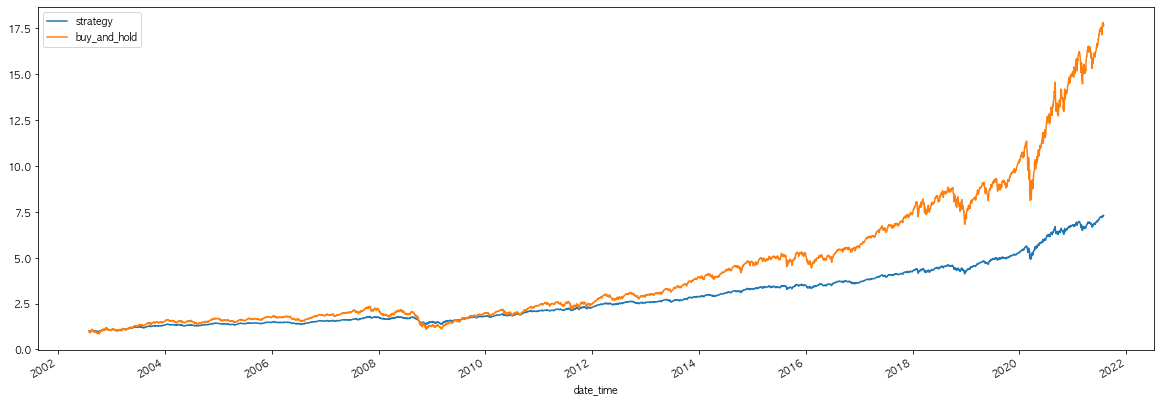

In [54]:
compare_df.plot(figsize=(20, 7));

In [55]:
utils.get_sharpe_ratio(utils.get_returns_df(compare_df, log=True)).to_frame("Sharpe Ratio")

,Sharpe Ratio
strategy,0.794
buy_and_hold,0.577


In [56]:
utils.get_CAGR_series(compare_df).to_frame("CAGR")

,CAGR
strategy,0.109
buy_and_hold,0.162


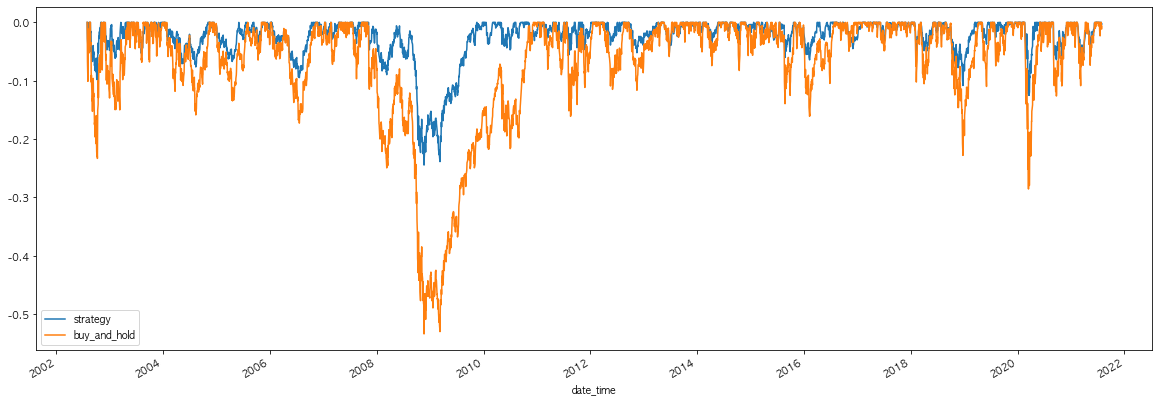

In [57]:
dd_df, mdd_series, longest_dd_period_df = utils.get_drawdown_infos(compare_df)
dd_df.plot(figsize=(20, 7));

In [58]:
mdd_series.to_frame("MDD")

,MDD
strategy,-0.245
buy_and_hold,-0.534


In [59]:
longest_dd_period_df

,drawdown mean,drawdown std,longest days,longest period
strategy,9,37,741,2007-11-06 ~ 2009-11-16
buy_and_hold,11,54,1134,2007-10-31 ~ 2010-12-08


## 4.2. 각자 해볼 만한 것

- 비중변경: 60:40 등
- rebal period 변경: monthly, yearly, half year, quarterly
  - 월초, 월말
  - 그래도 곡선은 daily로 tracking됨
- 본인만의 종목 구성(TQQQ:TLT)
- 함수화

## 4.3. 실전 투입 관련 - 1

- 슬리피지, 수수료, 세금
  - 리벨런싱에서 cum_rtn_at_last_month_end의 값을 전파할때 penalty
- 배당
  - 리벨런싱에서 cum_rtn_at_last_month_end의 값을 전파할때 advantage
- 추가매입(물타기)
  - 리벨런싱
    - cum_rtn_at_last_month_end의 값을 전파할때 advantage
  - 특정 %하락 or MDD 갱신 시

In [62]:
from functools import reduce

cum_rtn_at_last_month_end = 100000
individual_port_val_df_list = []

prev_end_day = rebal_index[0]
for end_day in rebal_index[1:]:
    sub_price_df = price_df.loc[prev_end_day:end_day]
    sub_cum_rtn_df = sub_price_df / sub_price_df.iloc[0]
    
    weight_series = target_weight_df.loc[prev_end_day]
    indi_port_cum_rtn_df = (sub_cum_rtn_df * weight_series) * cum_rtn_at_last_month_end
    individual_port_val_df_list.append(indi_port_cum_rtn_df)

    total_port_cum_rtn_series = indi_port_cum_rtn_df.sum(axis=1)
    # cum_rtn_at_last_month_end = total_port_cum_rtn_series.iloc[-1] # Normal
    cum_rtn_at_last_month_end = total_port_cum_rtn_series.iloc[-1] * 0.999 # Penalty

    prev_end_day = end_day

In [61]:
all_ind_portval_df1 = reduce(lambda x, y: pd.concat([x, y.iloc[1:]]), individual_port_val_df_list)
all_portval_df1 = all_ind_portval_df1.sum(axis=1)

In [63]:
all_ind_portval_df2 = reduce(lambda x, y: pd.concat([x, y.iloc[1:]]), individual_port_val_df_list)
all_portval_df2 = all_ind_portval_df2.sum(axis=1)

<AxesSubplot:xlabel='date_time'>

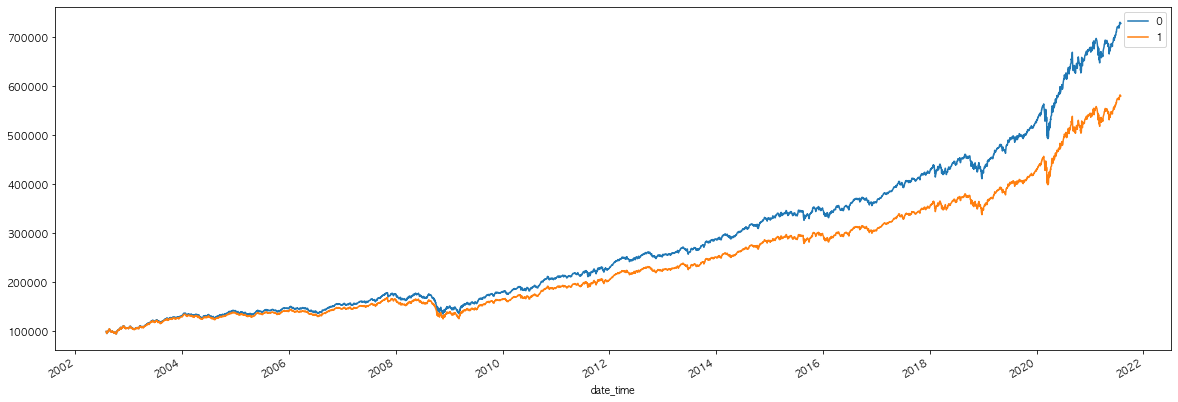

In [65]:
pd.concat([all_portval_df1, all_portval_df2], axis=1).plot(figsize=(20, 7))

## 실전 투입 관련 - 2

- 새로운 데이터 인입 --> 몇 주 사고 팔고?

In [66]:
price_df = pd.read_csv("class_materials/data/us_etf_1.csv", index_col=[0], parse_dates=True).drop(
    ["SHY", "TLT", "SPY"], axis=1
).loc["2021-06-30":]

price_df['year'] =  price_df.index.year
price_df['month'] = price_df.index.month

rebal_index = price_df.drop_duplicates(subset=['year', 'month'], keep='last').index
price_df = price_df.drop(['year', 'month'], axis=1)

target_weight_df = pd.DataFrame(
    [[1/len(price_df.columns)]*len(price_df.columns)]* len(rebal_index),
    index=rebal_index,
    columns=price_df.columns
)

price_df.tail(2)
target_weight_df.tail(2)

,IEF,QQQ
date_time,,
2021-07-29,117.380,366.480
2021-07-30,117.710,364.570


,IEF,QQQ
date_time,,
2021-06-30,0.500,0.500
2021-07-30,0.500,0.500


In [67]:
cum_rtn_at_last_month_end = 169324
individual_port_val_df_list = []

prev_end_day = rebal_index[0]
for end_day in rebal_index[1:]:
    sub_price_df = price_df.loc[prev_end_day:end_day]
    sub_cum_rtn_df = sub_price_df / sub_price_df.iloc[0]
    
    weight_series = target_weight_df.loc[prev_end_day]
    indi_port_cum_rtn_df = (sub_cum_rtn_df * weight_series) * cum_rtn_at_last_month_end
    
    individual_port_val_df_list.append(indi_port_cum_rtn_df)

    total_port_cum_rtn_series = indi_port_cum_rtn_df.sum(axis=1)
    cum_rtn_at_last_month_end = total_port_cum_rtn_series.iloc[-1]

    prev_end_day = end_day

In [68]:
indi_port_cum_rtn_df

,IEF,QQQ
date_time,,
2021-06-30,84662.000,84662.000
2021-07-01,84601.115,84695.442
2021-07-02,84909.209,85667.634
2021-07-06,85356.678,86037.880
2021-07-07,85606.088,86219.420
2021-07-08,85826.155,85698.687
2021-07-09,85393.356,86233.752
2021-07-12,85349.343,86570.556
2021-07-13,85085.262,86570.556


In [69]:
# 주의: 전략에 따라 scalar value or series가 될 수도 있음
target_portval = cum_rtn_at_last_month_end / sub_price_df.shape[1]
target_portval

86715.55104591169

In [70]:
diff = target_portval - indi_port_cum_rtn_df.iloc[-1]
diff

IEF    368.571
QQQ   -368.571
Name: 2021-07-30 00:00:00, dtype: float64

In [71]:
buy_or_sell_series = diff // sub_price_df.iloc[-1]
buy_or_sell_series

IEF    3.000
QQQ   -2.000
Name: 2021-07-30 00:00:00, dtype: float64

In [72]:
for ticker, qty in buy_or_sell_series.items():
    if qty > 0: 
        print("{}: {} x {}주 매수".format(ticker, sub_price_df.iloc[-1].loc[ticker], qty))
    elif qty < 0:
        print("{}: {} x {}주 매도".format(ticker, sub_price_df.iloc[-1].loc[ticker], qty * -1))

IEF: 117.71 x 3.0주 매수
QQQ: 364.57 x 2.0주 매도


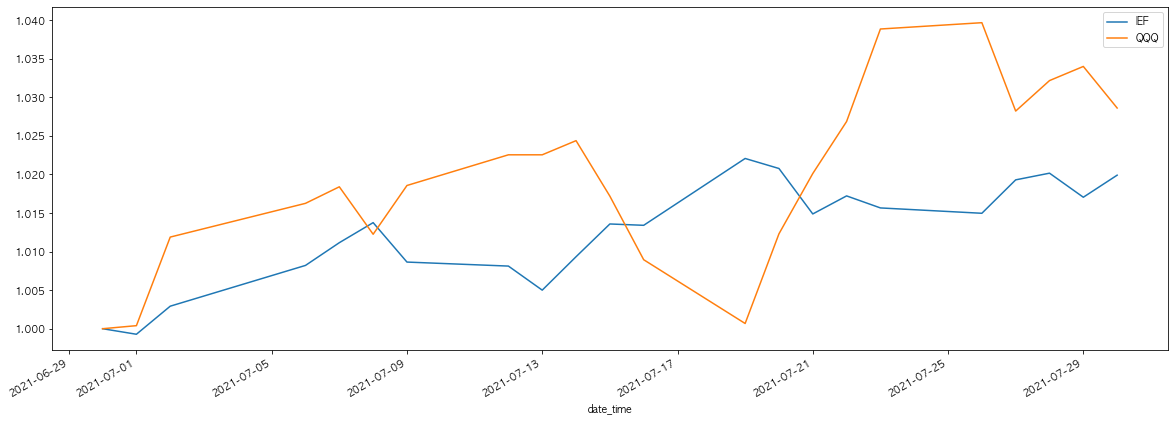

In [74]:
(sub_price_df / sub_price_df.iloc[0]).plot(figsize=(20, 7));

## 참고자료: 동일가중 vs 60:40 비교 코드

In [76]:
import matplotlib.pyplot as plt

from itertools import product
from functools import reduce


ticker_set_list = [
    ["SPY", "IEF"],
    ["SPY", "SHY"], 
    ["QQQ", "IEF"],
    ["QQQ", "SHY"],
]
weight_set_list = [[0.5, 0.5], [0.6, 0.4]]
rebal_set_list = ["month", "yearly"]

total_price_df = pd.read_csv("class_materials/data/us_etf_1.csv", index_col=[0], parse_dates=True).loc["2002-12-30":]
correct_answer_series_list = []
for ticker_set, weight_set, rebal_period in product(
    ticker_set_list, weight_set_list, rebal_set_list
):
    price_df = total_price_df[ticker_set]

    weight_df = price_df.copy()
    weight_df.loc[:, :] = weight_set

    if rebal_period == "month":
        weight_df['year'] = weight_df.index.year
        weight_df['month'] = weight_df.index.month

        rebal_weight_df = weight_df.drop_duplicates(subset=['year', 'month'], keep='last')
        rebal_weight_df = rebal_weight_df.drop(['year', 'month'], axis=1)
    else:
        weight_df['year'] = weight_df.index.year

        rebal_weight_df = weight_df.drop_duplicates(subset=['year'], keep='last')
        rebal_weight_df = rebal_weight_df.drop(['year'], axis=1)

    first_day = rebal_weight_df.index[0]
    cum_rtn_at_last_month_end = 1
    concat_list = []
    for end_day in rebal_weight_df.index[1:]:
        one_month_price_df = price_df.loc[first_day:end_day]
        one_month_cum_df = one_month_price_df / one_month_price_df.iloc[0]

        weight_series = rebal_weight_df.loc[first_day]
        port_rtn_df = one_month_cum_df.multiply(weight_series)

        final_port_cum_rtn_series = port_rtn_df.sum(axis=1) * cum_rtn_at_last_month_end
        concat_list.append(final_port_cum_rtn_series)

        cum_rtn_at_last_month_end = final_port_cum_rtn_series.iloc[-1]
        first_day = end_day

    correct_answer_series = reduce(lambda x, y: pd.concat([x, y.iloc[1:]]), concat_list)
    correct_answer_series.name = "_".join(ticker_set) + "_" + "_".join([str(w) for w in weight_set]) + "_" + rebal_period

    correct_answer_series_list.append(correct_answer_series)

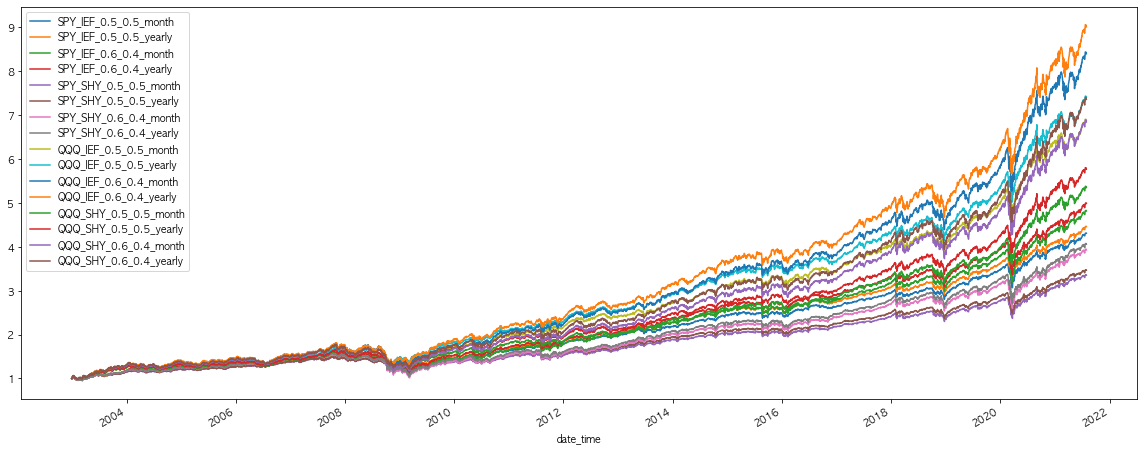

In [78]:
portval_df = pd.concat(correct_answer_series_list, axis=1)
portval_df.plot(figsize=(20, 8));

In [79]:
a = utils.get_sharpe_ratio(utils.get_returns_df(portval_df, log=True)).to_frame("Sharpe Ratio")
b = utils.get_CAGR_series(portval_df).to_frame("CAGR")
dd_df, mdd_series, longest_dd_period_df = utils.get_drawdown_infos(portval_df)
c = mdd_series.to_frame("MDD")

In [80]:
a.sort_values("Sharpe Ratio", ascending=False).head(30)

,Sharpe Ratio
QQQ_IEF_0.5_0.5_yearly,0.854
QQQ_IEF_0.5_0.5_month,0.807
QQQ_IEF_0.6_0.4_yearly,0.793
QQQ_IEF_0.6_0.4_month,0.753
SPY_IEF_0.5_0.5_yearly,0.690
QQQ_SHY_0.5_0.5_yearly,0.675
QQQ_SHY_0.6_0.4_yearly,0.665
QQQ_SHY_0.5_0.5_month,0.636
SPY_IEF_0.5_0.5_month,0.634
QQQ_SHY_0.6_0.4_month,0.632


In [81]:
longest_dd_period_df

,drawdown mean,drawdown std,longest days,longest period
SPY_IEF_0.5_0.5_month,9,41,970,2007-12-06 ~ 2010-08-02
SPY_IEF_0.5_0.5_yearly,8,35,769,2007-12-06 ~ 2010-01-13
SPY_IEF_0.6_0.4_month,9,43,1033,2007-12-10 ~ 2010-10-08
SPY_IEF_0.6_0.4_yearly,9,39,918,2007-10-09 ~ 2010-04-14
SPY_SHY_0.5_0.5_month,9,49,1170,2007-10-09 ~ 2010-12-22
SPY_SHY_0.5_0.5_yearly,9,48,1122,2007-10-09 ~ 2010-11-04
SPY_SHY_0.6_0.4_month,10,52,1217,2007-10-09 ~ 2011-02-07
SPY_SHY_0.6_0.4_yearly,10,52,1182,2007-10-09 ~ 2011-01-03
QQQ_IEF_0.5_0.5_month,9,37,741,2007-11-06 ~ 2009-11-16
QQQ_IEF_0.5_0.5_yearly,9,35,672,2007-11-06 ~ 2009-09-08


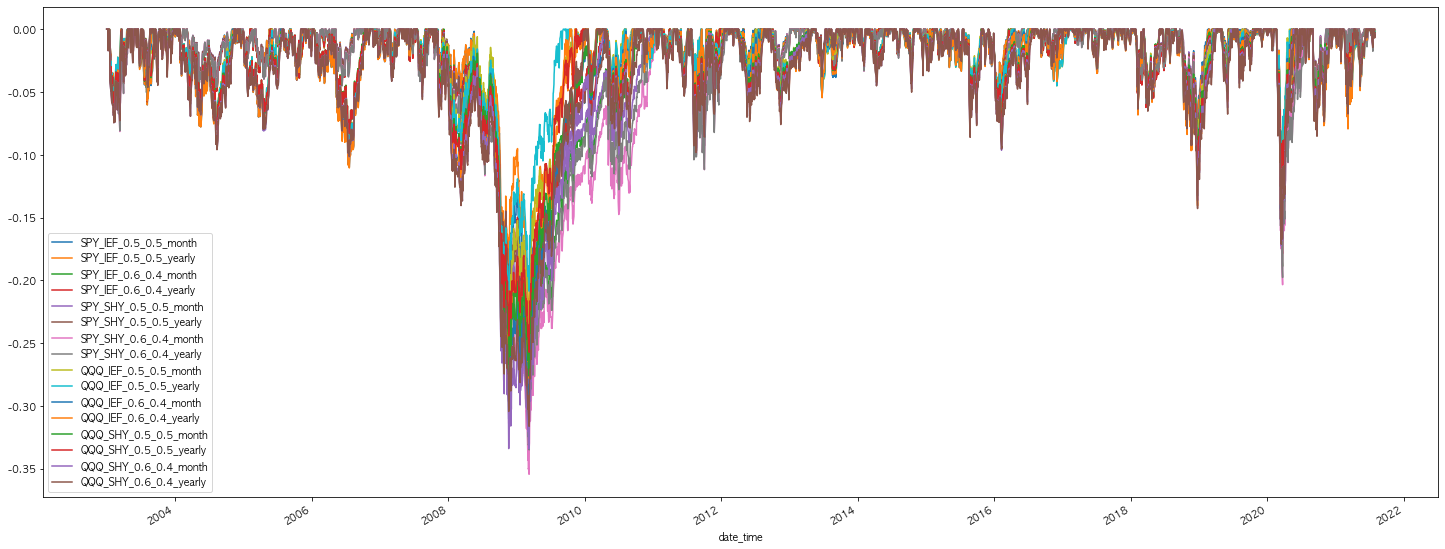

In [84]:
dd_df.plot(figsize=(25, 10));

In [85]:
pd.concat([a, b, c], axis=1).sort_values(["Sharpe Ratio", "CAGR"], ascending=False)

,Sharpe Ratio,CAGR,MDD
QQQ_IEF_0.5_0.5_yearly,0.854,0.113,-0.209
QQQ_IEF_0.5_0.5_month,0.807,0.109,-0.245
QQQ_IEF_0.6_0.4_yearly,0.793,0.125,-0.278
QQQ_IEF_0.6_0.4_month,0.753,0.120,-0.310
SPY_IEF_0.5_0.5_yearly,0.690,0.083,-0.229
QQQ_SHY_0.5_0.5_yearly,0.675,0.098,-0.257
QQQ_SHY_0.6_0.4_yearly,0.665,0.113,-0.316
QQQ_SHY_0.5_0.5_month,0.636,0.094,-0.276
SPY_IEF_0.5_0.5_month,0.634,0.081,-0.261
QQQ_SHY_0.6_0.4_month,0.632,0.108,-0.334
